In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv("datasets/twitter_training.csv", header=None)
df_val = pd.read_csv("datasets/twitter_validation.csv", header=None)

In [3]:
df_train.columns = ['tweet_id', 'entity', 'sentiment', 'text']
df_val.columns = ['tweet_id', 'entity', 'sentiment', 'text']

In [4]:
display(df_train.head())

,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
print(f"Training shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")

Training shape: (74682, 4)
Validation shape: (1000, 4)


C:\Users\nikun\AppData\Local\Temp\ipykernel_19012\2283401036.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='sentiment', order=df_train['sentiment'].value_counts().index, palette='Set2')


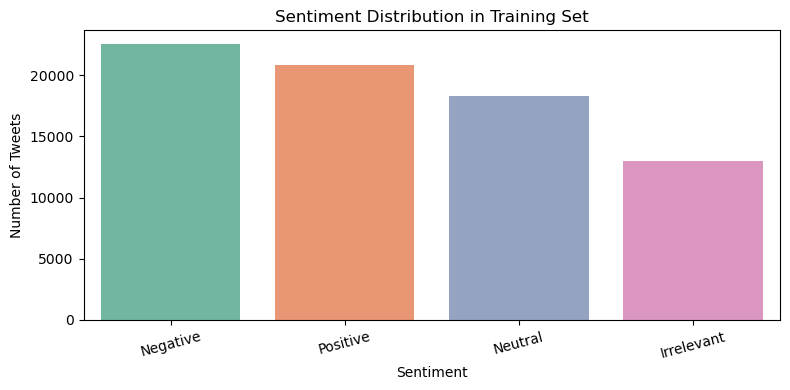

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_train, x='sentiment', order=df_train['sentiment'].value_counts().index, palette='Set2')
plt.title("Sentiment Distribution in Training Set")
plt.ylabel("Number of Tweets")
plt.xlabel("Sentiment")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("assets/sentiment_count.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    text = str(text).lower()                             # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)                 # Remove mentions/hashtags
    text = re.sub(r'[^a-z\s]', '', text)                 # Remove punctuation & numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text.strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df_train['clean_text'] = df_train['text'].apply(clean_tweet)
df_val['clean_text'] = df_val['text'].apply(clean_tweet)

In [10]:
df_train[['text', 'clean_text']].head()

,text,clean_text
0,im getting on borderlands and i will murder yo...,im getting borderlands murder
1,I am coming to the borders and I will kill you...,coming borders kill
2,im getting on borderlands and i will kill you ...,im getting borderlands kill
3,im coming on borderlands and i will murder you...,im coming borderlands murder
4,im getting on borderlands 2 and i will murder ...,im getting borderlands murder


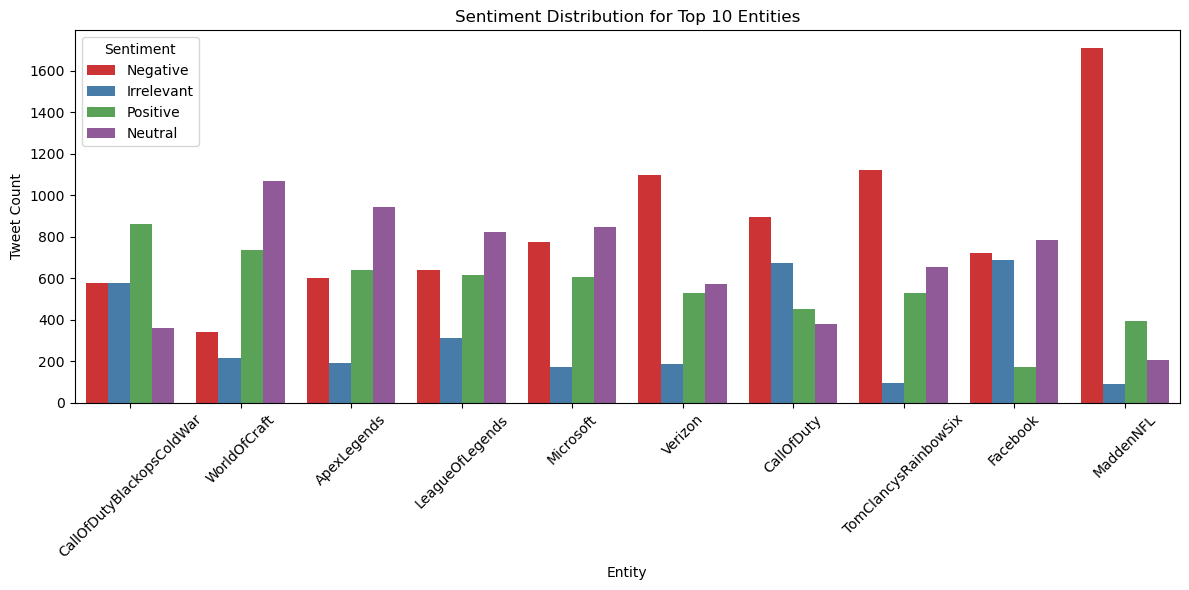

In [11]:
top_entities = df_train['entity'].value_counts().head(10).index

plt.figure(figsize=(12, 6))
sns.countplot(data=df_train[df_train['entity'].isin(top_entities)],
              x='entity', hue='sentiment', palette='Set1')
plt.title("Sentiment Distribution for Top 10 Entities")
plt.xlabel("Entity")
plt.ylabel("Tweet Count")
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("assets/sentiment_per_entity.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
from wordcloud import WordCloud

def plot_wordcloud(data, title, color):
    wc = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(' '.join(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens')
wc.generate(' '.join(df_train[df_train['sentiment'] == 'Positive']['clean_text']))
wc.to_file("assets/wordcloud_positive.png")

wc2 = WordCloud(width=800, height=400, background_color='white', colormap='Reds')
wc2.generate(' '.join(df_train[df_train['sentiment'] == 'Negative']['clean_text']))
wc2.to_file("assets/wordcloud_negative.png")

wc3 = WordCloud(width=800, height=400, background_color='white', colormap='Blues')
wc3.generate(' '.join(df_train[df_train['sentiment'] == 'Neutral']['clean_text']))
wc3.to_file("assets/wordcloud_neutral.png")


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])
X_val_tfidf = tfidf.transform(df_val['clean_text'])

y_train = df_train['sentiment']
y_val = df_val['sentiment']

In [14]:
print("TF-IDF Matrix for Training Set:", X_train_tfidf.shape)
print("TF-IDF Matrix for Validation Set:", X_val_tfidf.shape)

TF-IDF Matrix for Training Set: (74682, 5000)
TF-IDF Matrix for Validation Set: (1000, 5000)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_val_tfidf)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

  Irrelevant       0.76      0.69      0.72       172
    Negative       0.75      0.87      0.80       266
     Neutral       0.84      0.72      0.78       285
    Positive       0.80      0.84      0.82       277

    accuracy                           0.79      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.79      0.79      0.79      1000



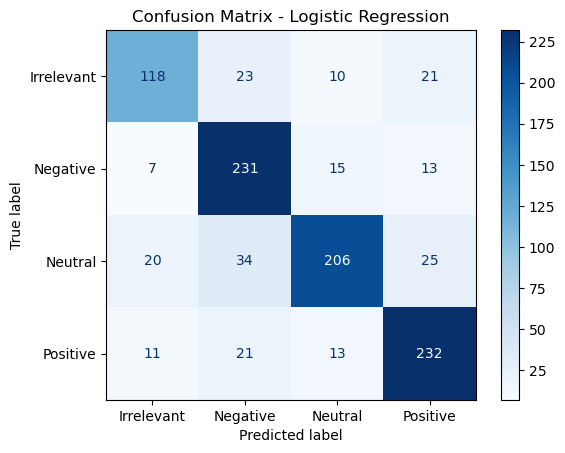

In [16]:
cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig("assets/confusion_matrix_sentiment.png", dpi=300, bbox_inches='tight')
plt.show()